In [1]:
# import the package 
import cobra
#import cobra.test
import pandas as pd
import numpy as np

pd.options.display.max_rows = 4000
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [2]:
ipfa = cobra.io.read_sbml_model("ipfasbml.xml")

Model does not contain SBML fbc package information.
'' is not a valid SBML 'SId'.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_C00001_c "H2O">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_C00002_c "ATP">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_C00003_c "NAD+">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_C00004_c "NADH">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_C00005_c "NADPH">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_C00006_c "NADP+">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Speci

In [4]:
print(ipfa.objective.expression)

1.0*Biomass_rxn_c - 1.0*Biomass_rxn_c_reverse_ec6c7


In [5]:
exchange_rxns = [exchange.id for exchange in ipfa.exchanges] # find exchange reactions
len(exchange_rxns)

241

In [6]:
ipfa.reactions.EXC_BOTH_C00062_e

Reaction identifier,EXC_BOTH_C00062_e
Name,EXC_BOTH_C00062_e
Memory address,0x7f133a182800
Stoichiometry,C00062_e <=> L-Arginine <=>
GPR,
Lower bound,-50.0
Upper bound,50.0


In [7]:
ipfa.compartments

{'c': 'Cytoplasm',
 'a': 'Apicoplast',
 'r': 'Endoplasmic_reticulum',
 'm': 'Mitochondrion',
 'n': 'Nucleus',
 'e': 'Extracellular'}

In [8]:
# find all substrates of the reaction
biomets = ipfa.reactions.Biomass_rxn_c.metabolites #r_4041 = biomassreaction 8

s = list(biomets.values()) #stoichiometry of the metabolites in the reaction
m = list(biomets.keys()) # ID of the metabolite in the reaction

# print a table of metabolites and their stoichiometry

metname = [mi.name for mi in m]# names of the metabolite in the reaction

# table printing (this is very messy)

biomass = pd.DataFrame.from_records(map(list, zip(*[m,metname,s])),columns=['ID', 'metabolite','stoichiometry'])
biomass.sort_values(by='metabolite', ascending='False')

,ID,metabolite,stoichiometry
64,C00712_c,(9Z)-Octadecenoic acid,-0.001
51,C00641_c,"1,2-Diacyl-sn-glycerol",-0.003
43,C00234_c,10-Formyltetrahydrofolate,-0.015
38,C00143_c,"5,10-Methylenetetrahydrofolate",-0.015
69,C00440_c,5-Methyltetrahydrofolate,-0.015
74,C00008_c,ADP,21.360
1,C00002_c,ATP,-21.406
77,Biomass_c,Biomass,1.000
68,C00120_c,Biotin,-0.008
21,C00063_c,CTP,-0.013


In [9]:

'''
cobra.flux_analysis.pfba(model: cobra.Model, fraction_of_optimum: float = 1.0, objective: Union[Dict, optlang.interface.Objective, None] = None, reactions: Optional[List[cobra.Reaction]] = None) → cobra.Solution
minimizes overall fluxes
'''
opt = ipfa.optimize()
lethal = 0
frac = opt.objective_value * 0.9


In [10]:
ipfa.reactions.T_c_to_e_C00255

Reaction identifier,T_c_to_e_C00255
Name,T_c_to_e_C00255
Memory address,0x7f133a31d8d0
Stoichiometry,C00255_c <=> C00255_e Riboflavin <=> Riboflavin
GPR,
Lower bound,-50.0
Upper bound,50.0


In [11]:
'''
ipfa extra lipids in biomass

Neutral: cardiolipin, 1,2 diacyl-gycerol,
Fatty acids: Octadecanoic acid, Hexadecanoic acid, (9Z)-Octadecenoic acid, Tetradecanoic acid
'''
lipids = ['Cholesterol','Phosphatidylcholine','Phosphatidylserine','Phosphatidylethanolamine','Sphingomyelin','Triacylglycerol']
all_lps = ['cardiolipin','1,2 diacyl-gycerol','Octadecanoic acid','Hexadecanoic acid', '(9Z)-Octadecenoic acid', 'Tetradecanoic acid']
lipid_df = biomass.loc[biomass['metabolite'].isin(lipids)]
lipid_df['ID']

55    C00157_r
56    C00350_r
57    C02737_r
61    C00550_c
62    C00187_c
63    C00422_c
Name: ID, dtype: object

/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0, 0.5, 'Phases value')

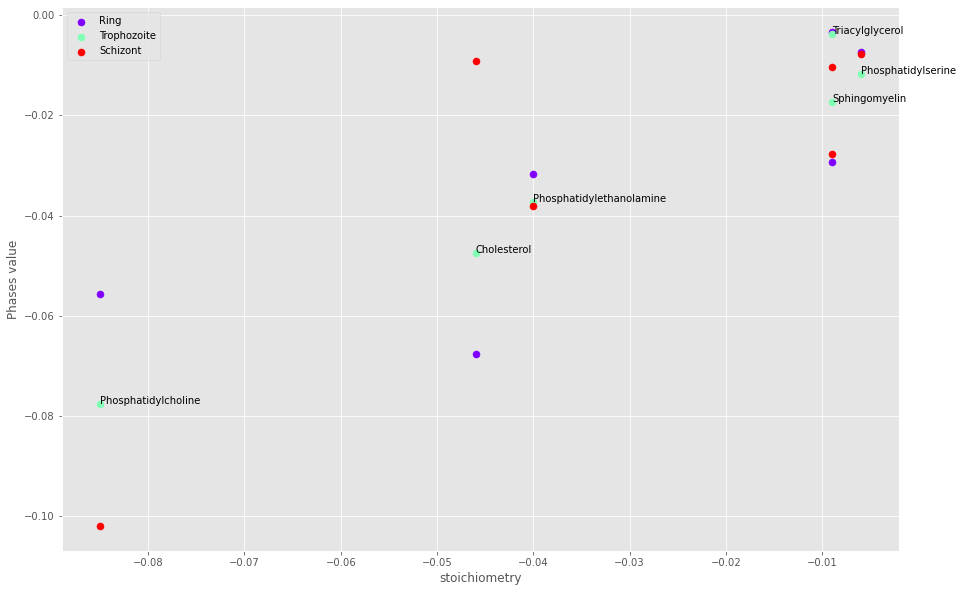

In [12]:
# first  value % of total lipids containing a lipid(PLs, SM, Cholesterol, Neutral)
# 45.7*58.4 is 45.7% phospholipids of total lipid amount times 58.4% of PC in PLs
# divided by 100 to have %
# values % of specific lipid during this stage of total lipid amount
newlipid_df = lipid_df.assign(  Ring=[45.7*58.4/100,45.7*33.2/100,45.7*7.7/100,14.0,32.4,7.9*20.4/100])
newlipid_df = newlipid_df.assign(  Trophozoite=[60.1*59.8/100,60.1*28.7/100,60.1*9.1/100,8.0,22.0,10.0*17.5/100])
newlipid_df = newlipid_df.assign(  Schizont=[69.1*66.4/100,69.1*24.8/100,69.1*5.0/100,12.5,4.1,33.0*14.2/100])

from matplotlib.pyplot import cm

phases = ['Ring', 'Trophozoite', 'Schizont']

fig, ax = plt.subplots(figsize=(15,10))
color=iter(cm.rainbow(np.linspace(0,1,len(phases))))

for phase in phases:
    newlipid_df[phase] = newlipid_df[phase]/newlipid_df[phase].sum()*newlipid_df.stoichiometry.sum()
    c=next(color)
    if phase == 'Trophozoite':
        for i, txt in enumerate(newlipid_df['metabolite']):
            ax.annotate(txt, xy=(newlipid_df['stoichiometry'].iat[i], newlipid_df[phase].iat[i]))
    ax = newlipid_df.plot.scatter(x='stoichiometry', y = phase, color=c, label=phase, s=50, ax=ax)
plt.ylabel('Phases value')

In [13]:
newlipid_df

,ID,metabolite,stoichiometry,Ring,Trophozoite,Schizont
55,C00157_r,Phosphatidylcholine,-0.085,-0.055726,-0.077518,-0.101949
56,C00350_r,Phosphatidylethanolamine,-0.040,-0.031680,-0.037204,-0.038077
57,C02737_r,Phosphatidylserine,-0.006,-0.007347,-0.011796,-0.007677
61,C00550_c,Sphingomyelin,-0.009,-0.029232,-0.017255,-0.027775
62,C00187_c,Cholesterol,-0.046,-0.067651,-0.047452,-0.009110
63,C00422_c,Triacylglycerol,-0.009,-0.003365,-0.003775,-0.010412


In [41]:
#get id from weird reaction datatype(frozenset)
def id_rct_conv(x):
    st = str(x)
    lst = st.split(',')
    react = []
    for e in lst:
        start = e.find('Reaction ')
        end = e.find(' at')
        e = e[start+len('Reaction '):end]
        react.append(e)
    return(react)

# get names of metabolites involved in reaction
def get_metas_rxn(rxn):
    biomets = ipfa.reactions.get_by_id(rxn).metabolites

    m = list(biomets.keys()) # ID of the metabolite in the reaction
    metname = [mi.name for mi in m] # names of the metabolite in the reaction
    return metname

# get id of metabolites involved in reaction
def get_id_metas_rxn(rxn):
    biomets = ipfa.reactions.get_by_id(rxn).metabolites

    m = list(biomets.keys()) # ID of the metabolite in the reaction
    return m


#get actual names of reactions(names) for list of reaction ids(x)
def nme_rct_lst(x):
    names = []
    for val in x:
        name=str(val)
        names.append(ipfa.reactions.get_by_id(name).name)
        
    return names   

#get actual fluxes of reactions(names) for list of reaction ids(x)
def flux_rct_lst(x):
    fluxes = []
    for val in x:
        fl=str(val)
        fluxes.append(ipfa.reactions.get_by_id(fl).flux)
        
    return fluxes   

#get all reactions(ID,name) in which metabolite(x) is involved converted to panda table
def print_reactions(x):
    b = ipfa.metabolites.get_by_id(x).reactions

    idnme = id_rct_conv(b)
    nm = nme_rct_lst(idnme)
    
    # table returning (this is very messy)
    import pandas as pd
    df = pd.DataFrame.from_records(map(list, zip(*[idnme,nm])),columns=['ID', 'name'])
    return df

#get all reactions(ID,name) with its corresponding flux in which metabolite(x) is involved converted to panda table
def print_rct_wth_flux(x):
    b = ipfa.metabolites.get_by_id(x).reactions
    idnme = id_rct_conv(b)
    nm = nme_rct_lst(idnme)
    fls= flux_rct_lst(idnme)
    
    # table returning (this is very messy)
    df = pd.DataFrame.from_records(map(list, zip(*[idnme,nm,fls])),columns=['ID', 'name','flux'])
    #create table with reactions that have flux
    df = df[df['flux'] > 0]
    dna_s = df.dropna( axis=1, how='any')
    
    return dna_s

#get all metabolites involed in ripfa.metabolites.get_by_id('C00269_c').summary()eaction(x) with their stoichometric factor in panda data frame
def print_stoich_reaction(x):
    # find all substrates of the reaction
    biomets = ipfa.reactions.get_by_id(x).metabolites

    s = list(biomets.values()) #stoichiometry of the metabolites in the reaction
    m = list(biomets.keys()) # ID of the metabolite in the reaction

    # a table of metabolites and their stoichiometry

    metname = [mi.name for mi in m] # names of the metabolite in the reaction

    # panda table creating (this is very messy)
    import pandas as pd

    df = pd.DataFrame.from_records(map(list, zip(*[m,metname,s])),columns=['ID', 'metabolite','stoichiometry'])
    return df

def summary_wth_names(print_on=True):
    # find all excretion reactions
    exrxns = ipfa.exchanges
    rxnids = [e.id for e in exrxns]

    # get values for their bounds
    # exrxns[1]oo
    # exrxns[1].bounds
    b = [e.flux for e in exrxns]  # flux of the reaction
    metname = [get_metas_rxn(r) for r in rxnids]  # names of the reaction
    metaids = [get_id_metas_rxn(r) for r in rxnids]
    # table printing (this is very messy)
    df=pd.DataFrame.from_records(map(list, zip(*[metaids,metname,b])),columns=['IDs','Names','flux'])

    #out flux sorted
    outflux=df[df['flux'] > 0.1E-04]
    outflux=outflux.sort_values('flux',ascending=False)
    outflux= outflux.reset_index(drop=True)
    
    #in flux sorted
    influx=df[df['flux'] < -0.1E-04]
    influx=influx.sort_values('flux',ascending=True)
    influx = influx.reset_index(drop=True)
    #joining of dataframes
    dr=influx.join(outflux,lsuffix='_IN Flux',rsuffix='_OUT Flux')
    #make NaN to empty strings
    show = dr.replace(np.nan, '', regex=True)
    #make two headings out of (Names_IN Flux) Names as sub and IN Flux above
    show.columns = pd.MultiIndex.from_tuples([tuple(list(reversed(c.split('_')))) for c in show.columns])
    if print_on:
        print(show)
    return show

In [15]:
print_rct_wth_flux('C00157_r')

,ID,name,flux
1,Biomass_rxn_c,Biomass_rxn,0.160182


In [16]:
print_reactions('C00157_r')

,ID,name
0,R07377_r,
1,Biomass_rxn_c,Biomass_rxn
2,R01321_r,"CDP-choline:1,2-diacyl-sn-glycerol cholinephos..."


In [17]:
# read file to get all reactions in subsystem of interest
table = pd.read_excel('ipfa_raven_input.xlsx', header=0)
# these are the 'subsytems' we want to concentrate on, list not complete
subsystems = ['Fatty acid degradation', 'Glycerophospholipid metabolism',
              'Glycerolipid metabolism', 'Ether lipid metabolism', 'N-Glycan biosynthesis',
              'Lipoic acid metabolism', 'Phosphonate and phosphinate metabolism',
              'Sphingolipid metabolism', 'Fatty acid metabolism / biotin (vit B7) dependent',
              'Fatty acid metabolism', 'Isoprenoid metabolism', 'Steroid metabolism',
              'Glycosylphosphatidylinositol(GPI)-anchor biosynthesis']

table = table.loc[:, 'ID':] # cut empty column
table = table[table['SUBSYSTEM'].isin(subsystems)] # select only rows with right subsystem

/usr/lib/python3/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [18]:
table.sort_values(by='ID')

,ID,NAME,EQUATION,EC-NUMBER,GENE ASSOCIATION,LOWER BOUND,UPPER BOUND,OBJECTIVE,COMPARTMENT,SUBSYSTEM,MIRIAM,REPLACEMENT ID
877,FA_pool_c,FA_pool_c,Fatty acid[c] <=> 0.39 Hexadecanoic acid[c] + ...,',NaN,-50.0,50,NaN,NaN,Fatty acid metabolism,NaN,NaN
313,R00014_a,pyruvate:thiamin diphosphate acetaldehydetrans...,Pyruvate[a] + Thiamin diphosphate[a] + H+[a] <...,1.2.4.1 2.2.1.6 4.1.1.1,PF3D7_1124500:PF3D7_1446400,0.0,50,NaN,NaN,Isoprenoid metabolism,NaN,NaN
318,R00200_a,ATP:pyruvate 2-O-phosphotransferase,ATP[a] + Pyruvate[a] <=> ADP[a] + Phosphoenolp...,2.7.1.40,PF3D7_1037100,-50.0,50,NaN,NaN,Isoprenoid metabolism,NaN,NaN
466,R00238_m,Acetyl-CoA:acetyl-CoA C-acetyltransferase,2 Acetyl-CoA[m] <=> CoA[m] + Acetoacetyl-CoA[m],2.3.1.9,PF3D7_1450900,-50.0,50,NaN,NaN,Fatty acid degradation,NaN,NaN
324,R00742_a,Acetyl-CoA:carbon-dioxide ligase (ADP-forming),ATP[a] + Acetyl-CoA[a] + HCO3-[a] <=> ADP[a] +...,6.4.1.2,PF3D7_1469600,-50.0,50,NaN,NaN,Fatty acid metabolism,NaN,NaN
958,R00742_r,Acetyl-CoA:carbon-dioxide ligase (ADP-forming),ATP[r] + Acetyl-CoA[r] + HCO3-[r] <=> ADP[r] +...,6.4.1.2,NaN,-50.0,50,NaN,NaN,Fatty acid metabolism,NaN,NaN
325,R00842_a,sn-Glycerol-3-phosphate:NAD+ 2-oxidoreductase,NAD+[a] + sn-Glycerol 3-phosphate[a] <=> NADH[...,1.1.1.8 1.1.1.94,PF3D7_1114800,-50.0,50,NaN,NaN,Glycerophospholipid metabolism,NaN,NaN
426,R00842_r,sn-Glycerol-3-phosphate:NAD+ 2-oxidoreductase,NAD+[r] + sn-Glycerol 3-phosphate[r] <=> NADH[...,1.1.1.8 1.1.1.94,PF3D7_1216200,-50.0,50,NaN,NaN,Glycerophospholipid metabolism,NaN,NaN
427,R00847_r,ATP:glycerol 3-phosphotransferase,ATP[r] + Glycerol[r] <=> ADP[r] + sn-Glycerol ...,2.7.1.30,PF3D7_1351600,-50.0,50,NaN,NaN,Glycerolipid metabolism,NaN,NaN
476,R00848_m,sn-Glycerol-3-phosphate:(acceptor) 2-oxidoredu...,FAD[m] + sn-Glycerol 3-phosphate[m] <=> Glycer...,1.1.5.3,PF3D7_0306400,-50.0,50,NaN,NaN,Glycerophospholipid metabolism,NaN,NaN


In [20]:
print('complete model: ', ipfa.optimize())
summary_wth_names()
#look at Oxyhemoglobin path in ipfa

complete model:  <Solution 0.160 at 0x7f13398dad70>
       IN Flux                                              OUT Flux  \
           IDs                           Names      flux         IDs   
0   [C00009_e]                [Orthophosphate] -0.270174  [C00001_e]   
1   [C00019_e]       [S-Adenosyl-L-methionine] -0.081212  [C00249_e]   
2   [C00836_e]                   [Sphinganine] -0.073817  [C00048_e]   
3   [C00159_e]                     [D-Mannose] -0.071361  [C00116_e]   
4   [C09332_e]      [Tetrahydrofolyl-[Glu](2)] -0.061804  [C00234_e]   
5   [C00036_e]                  [Oxaloacetate] -0.061510  [C00073_e]   
6   [C00122_e]                      [Fumarate] -0.054782  [C00330_e]   
7   [C00407_e]                  [L-Isoleucine] -0.052700  [C00013_e]   
8   [C01672_e]                    [Cadaverine] -0.044691  [C15587_e]   
9   [C20463_e]    [Purine deoxyribonucleoside] -0.030657  [C00311_e]   
10  [C00152_e]                  [L-Asparagine] -0.030114  [C00041_e]   
11  [C00295_

IN Flux                                              OUT Flux  \
           IDs                           Names      flux         IDs   
0   [C00009_e]                [Orthophosphate] -0.270174  [C00001_e]   
1   [C00019_e]       [S-Adenosyl-L-methionine] -0.081212  [C00249_e]   
2   [C00836_e]                   [Sphinganine] -0.073817  [C00048_e]   
3   [C00159_e]                     [D-Mannose] -0.071361  [C00116_e]   
4   [C09332_e]      [Tetrahydrofolyl-[Glu](2)] -0.061804  [C00234_e]   
5   [C00036_e]                  [Oxaloacetate] -0.061510  [C00073_e]   
6   [C00122_e]                      [Fumarate] -0.054782  [C00330_e]   
7   [C00407_e]                  [L-Isoleucine] -0.052700  [C00013_e]   
8   [C01672_e]                    [Cadaverine] -0.044691  [C15587_e]   
9   [C20463_e]    [Purine deoxyribonucleoside] -0.030657  [C00311_e]   
10  [C00152_e]                  [L-Asparagine] -0.030114  [C00041_e]   
11  [C00295_e]                       [Orotate] -0.027391  [C00106_e]   
12  [C00422_e]               [Triacylglycerol] -0.025469  [C12126_e]   
13  [C00082_e]                    [L-Tyrosine] -0.025469  [C16633_e]   
14  [C00189_e]                  [Ethanolamine] -0.020984  [C00155_e]   
15  [C00319_e]                   [Sphingosine] -0.019863  [C00088_e]   
16  [C00881_e]                 [Deoxycytidine] -0.019640  [C00183_e]   
17  [C07649_e]                          [5-FU] -0.017780  [C00135_e]   
18  [C00114_e]                       [Choline] -0.015057  [C00864_e]   
19  [C02763_e]  [2-Hydroxy-3-phenylpropenoate] -0.011693  [C00060_e]   
20  [C01165_e]    [L-Glutamate 5-semialdehyde] -0.011613  [C05198_e]   
21  [C00123_e]                     [L-Leucine] -0.011373  [C03912_e]   
22  [C00086_e]                          [Urea] -0.010732               
23  [C00188_e]                   [L-Threonine] -0.008490               
24  [C06453_e]               [Methylcobalamin] -0.007689               
25  [C00187_e]                   [Cholesterol] -0.007368               
26  [C00831_e]                   [Pantetheine] -0.007342               
27  [C03684_e]    [6-Pyruvoyltetrahydropterin] -0.006728               
28  [C00536_e]                  [Triphosphate] -0.006728               
29  [C00156_e]             [4-Hydroxybenzoate] -0.005927               
30  [C00255_e]                    [Riboflavin] -0.005446               
31  [C00153_e]                  [Nicotinamide] -0.005126               
32  [C00032_e]                          [Heme] -0.004165               
33  [C00033_e]                       [Acetate] -0.002723               
34  [C01419_e]                       [Cys-Gly] -0.002590               
35  [C00440_e]      [5-Methyltetrahydrofolate] -0.002403               
36  [C17023_e]                  [Sulfur donor] -0.001922               
37  [C16240_e]                    [Apoprotein] -0.001922               
38  [C00378_e]                      [Thiamine] -0.001442               
39  [C00120_e]                        [Biotin] -0.001281               
40  [C00669_e]   [gamma-L-Glutamyl-L-cysteine] -0.001281               
41  [C00725_e]                       [Lipoate] -0.000961               
42  [C05781_e]                 [Oxyhemoglobin] -0.000961               
43  [C00137_e]                  [myo-Inositol] -0.000641               
44  [C00750_e]                      [Spermine] -0.000400               
45  [C06424_e]            [Tetradecanoic acid] -0.000320               
46  [C00059_e]                       [Sulfate] -0.000160               
47  [C01530_e]             [Octadecanoic acid] -0.000160               
48  [C00712_e]        [(9Z)-Octadecenoic acid] -0.000160               
49  [C01595_e]                     [Linoleate] -0.000160               

                                               
                              Names      flux  
0                             [H2O]  0.170487  
1               [Hexadecanoic acid]  0.073497  
2                      [Glyoxylate]  0.065354  
3                     

In [21]:
newlipid_df

,ID,metabolite,stoichiometry,Ring,Trophozoite,Schizont
55,C00157_r,Phosphatidylcholine,-0.085,-0.055726,-0.077518,-0.101949
56,C00350_r,Phosphatidylethanolamine,-0.040,-0.031680,-0.037204,-0.038077
57,C02737_r,Phosphatidylserine,-0.006,-0.007347,-0.011796,-0.007677
61,C00550_c,Sphingomyelin,-0.009,-0.029232,-0.017255,-0.027775
62,C00187_c,Cholesterol,-0.046,-0.067651,-0.047452,-0.009110
63,C00422_c,Triacylglycerol,-0.009,-0.003365,-0.003775,-0.010412


In [42]:
# optimize iPFA for different phases and their corrosponding lipid values 
# stoichiometry is iPFA standard values
ex_flux_dict = {}
phases = ['stoichiometry', 'Ring', 'Trophozoite', 'Schizont']
for phase in phases:
    with ipfa:
        # loop to create and implement new stoichiometric values
        for meta in newlipid_df.ID:
            # creat new float value from table
            zero = float(newlipid_df.loc[newlipid_df['ID'] == meta]['stoichiometry'])
            new_stoich = float(newlipid_df.loc[newlipid_df['ID'] == meta][phase])
            # implement new value in biomass function
            ipfa.reactions.Biomass_rxn_c.add_metabolites({meta:new_stoich-zero})
        
        # print solution value and boundary fluxes
        print(phase+' model: ', ipfa.optimize().objective_value)

        print(ipfa.reactions.Biomass_rxn_c)
        # add to lipid-reaction-table the calculated fluxes through them 
        table[phase + '_Flux'] = flux_rct_lst(table['ID'].tolist())    
        
        
        #for i in newlipid_df.ID:
        #    exe='print(ipfa.metabolites.'+ str(i) +'.summary(threshold=0.00002))'
        #    exec(exe)
        ex_flux_dict[phase] = summary_wth_names(print_on=False)

stoichiometry model:  0.16018237082066866
Biomass_rxn_c: 21.36 C00001_c + 21.406 C00002_c + 0.016 C00003_c + 0.016 C00006_c + 0.016 C00010_c + 0.001 C00013_c + 0.001 C00014_c + 0.021 C00016_c + 0.006 C00018_c + 0.011 C00019_c + 0.248 C00025_c + 0.022 C00029_c + 0.026 C00032_m + 0.11 C00037_c + 0.085 C00041_c + 0.017 C00043_c + 0.013 C00044_c + 0.411 C00047_c + 0.432 C00049_c + 0.008 C00051_c + 0.005 C00052_c + 0.001 C00059_c + 0.013 C00061_c + 0.103 C00062_c + 0.013 C00063_c + 0.099 C00064_c + 0.223 C00065_c + 0.009 C00068_c + 0.078 C00073_c + 0.046 C00075_c + 0.018 C00078_c + 0.163 C00079_c + 0.195 C00082_c + 0.009 C00096_c + 0.064 C00097_c + 0.014 C00101_c + 0.008 C00120_c + 0.287 C00123_c + 0.004 C00129_c + 0.055 C00131_c + 0.003 C00134_c + 0.078 C00135_c + 0.015 C00143_c + 0.078 C00148_c + 0.248 C00152_c + 0.085 C00157_r + 0.145 C00183_c + 0.046 C00187_c + 0.149 C00188_c + 0.015 C00234_c + 0.002 C00249_c + 0.013 C00286_c + 0.005 C00315_c + 0.007 C00325_c + 0.04 C00350_r + 0.015 C00

In [43]:
phases = ['stoichiometry', 'Ring', 'Trophozoite', 'Schizont']

stoich = ex_flux_dict['stoichiometry']['OUT Flux']['flux'][ex_flux_dict['stoichiometry']['OUT Flux']['flux'] != '']

out_dataframe = pd.DataFrame()
in_dataframe = pd.DataFrame()

for current in ['IN','OUT']:
    for phase in phases:
        mini_frame = pd.DataFrame()
        mini_frame[phase +'_Names'] = ex_flux_dict[phase][current+' Flux']['Names'][ex_flux_dict[phase][current+' Flux']['Names'] != '']

        for i, name in enumerate(mini_frame[phase +'_Names']):
            mini_frame[phase +'_Names'].iloc[i] = name[0]

        phase_dataframe = ex_flux_dict[phase][current+' Flux']['flux'][ex_flux_dict[phase][current+' Flux']['flux'] != '']
        mini_frame[phase] = phase_dataframe

        mini_frame = mini_frame.sort_values(by=phase +'_Names', ascending='False',ignore_index=True)
        if current == 'OUT':
            out_dataframe = mini_frame.join(out_dataframe, how='outer')
        else:
            in_dataframe = mini_frame.join(in_dataframe, how='outer')

melted_df = out_dataframe.melt(id_vars=['Schizont_Names', 'Trophozoite_Names', 'Ring_Names', 'stoichiometry_Names'],
                    value_vars=['Schizont', 'Trophozoite', 'Ring', 'stoichiometry'],
                    var_name='Stage',
                    value_name='Value')
name_list = []
for i,stage in enumerate(melted_df['Stage']):
    name_list.append(melted_df[stage+'_Names'].iloc[i])
melted_df['name']=name_list
out_df = melted_df.drop(['Schizont_Names', 'Trophozoite_Names', 'Ring_Names', 'stoichiometry_Names'],axis=1)
out_df = out_df.dropna()

melted_df = in_dataframe.melt(id_vars=['Schizont_Names', 'Trophozoite_Names', 'Ring_Names', 'stoichiometry_Names'],
                    value_vars=['Schizont', 'Trophozoite', 'Ring', 'stoichiometry'],
                    var_name='Stage',
                    value_name='Value')
name_list = []
for i,stage in enumerate(melted_df['Stage']):
    name_list.append(melted_df[stage+'_Names'].iloc[i])
melted_df['name']=name_list
in_df = melted_df.drop(['Schizont_Names', 'Trophozoite_Names', 'Ring_Names', 'stoichiometry_Names'],axis=1)
in_df = in_df.dropna()

In [44]:
def plot_dataframe(df, description='',value_str=''):
    grouped_df = df.groupby(['name','Stage']).mean().reset_index()
    # Create a colormap and markers for the stages
    colormap = plt.cm.get_cmap('tab10')
    markers =  ("s","D","^","o")
    marks = iter(markers)

    # Plot the scatter plot
    fig, ax = plt.subplots(figsize=(7,15))

    # Iterate over each stage
    for i, stage in enumerate(grouped_df['Stage'].unique()):
        stage_data = grouped_df[grouped_df['Stage'] == stage]
        ax.scatter(stage_data[value_str+'Value'],stage_data['name'], color=colormap(i), label=stage, marker=next(marks))

    # Add labels and title
    ax.set_ylabel('Metabolite')
    ax.set_xlabel(description+'ward-Flux '+ value_str +' Value')
    #ax.set_title('Values by Name with Stage')

    # Add a legend
    ax.legend(grouped_df['Stage'].unique(), bbox_to_anchor=(0., 1.001, 1., .102), loc=3,ncol=4, mode="expand",fancybox = True, borderaxespad=0.)
    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    plt.tight_layout()

    # Show the plot
    plt.show()

In [45]:
out_df

,Stage,Value,name
0,Schizont,0.002566,(S)-1-Pyrroline-5-carboxylate
1,Schizont,0.060448,10-Formyltetrahydrofolate
2,Schizont,0.001922,5'-Deoxyadenosine
3,Schizont,0.01778,5-Fluorouridine
4,Schizont,0.051258,Deoxyguanosine
5,Schizont,0.018421,Dihydroceramide
6,Schizont,0.049025,Diphosphate
7,Schizont,0.078809,Glycerol
8,Schizont,0.061237,Glyoxylate
9,Schizont,0.171885,H2O


/tmp/ipykernel_2050372/2519664926.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10')


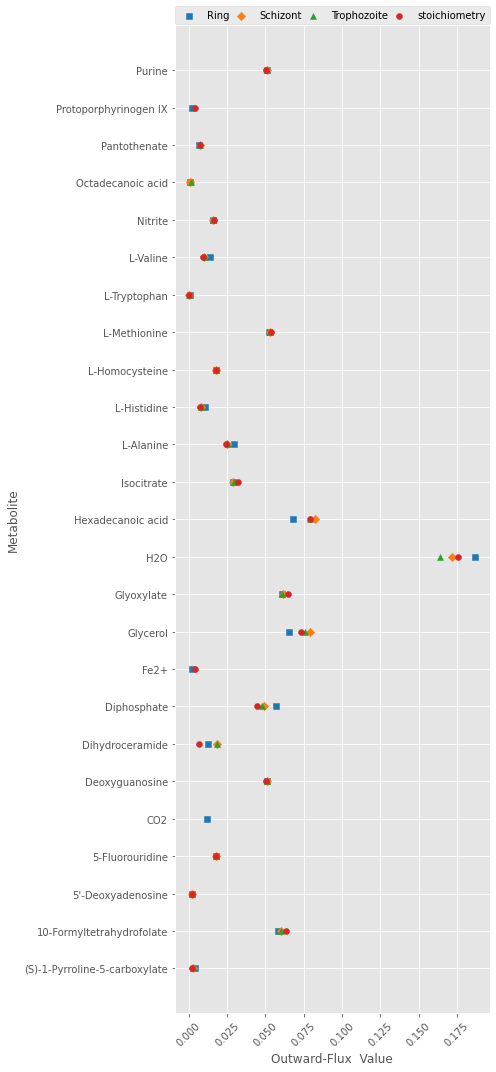

In [46]:
plot_dataframe(out_df,'Out')

/tmp/ipykernel_2050372/2519664926.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10')


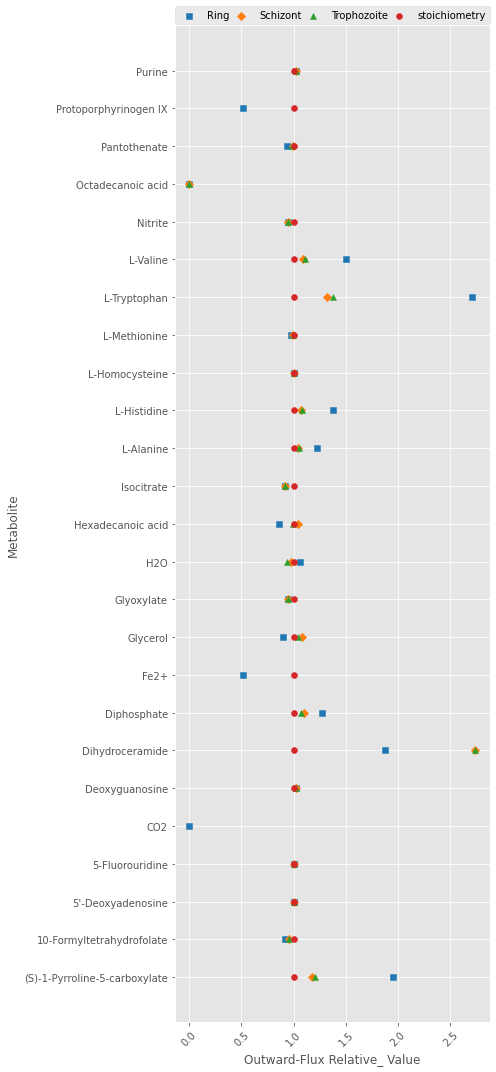

In [47]:
## Group the DataFrame by name
grouped_df = out_df.groupby(['name'])

# Define a function to calculate the relative value
def calculate_relative_value(x):
    if 'stoichiometry' in x['Stage'].values:
        stoichiometry_value = x.loc[x['Stage'] == 'stoichiometry', 'Value'].values[0]
        x['Relative_Value'] = x['Value'] / stoichiometry_value
    else:
        x['Relative_Value'] = 0
    return x

# Apply the transformation to each group
transformed_df = grouped_df.apply(calculate_relative_value)
transformed_df.drop('Value',axis=1)

plot_dataframe(transformed_df,'Out','Relative_')

/tmp/ipykernel_2050372/2519664926.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10')


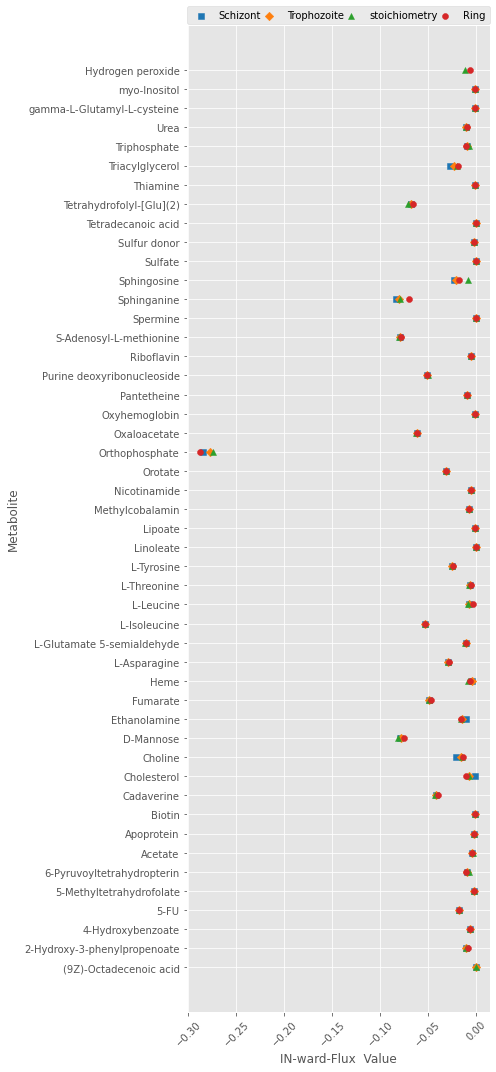

In [48]:
plot_dataframe(in_df,'IN-')

/tmp/ipykernel_2050372/2519664926.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10')


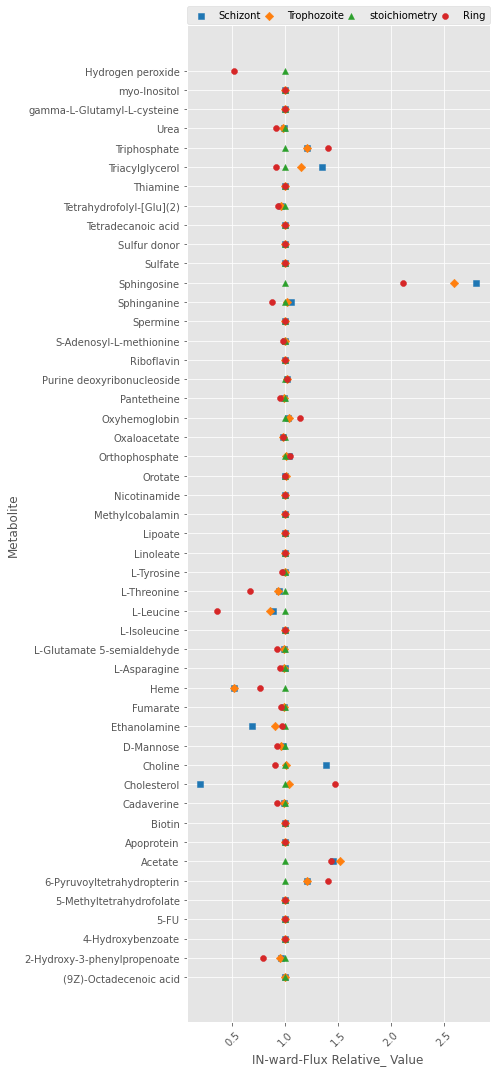

In [49]:
## Group the DataFrame by name
grouped_df = in_df.groupby(['name'])

# Define a function to calculate the relative value
def calculate_relative_value(x):
    if 'stoichiometry' in x['Stage'].values:
        stoichiometry_value = x.loc[x['Stage'] == 'stoichiometry', 'Value'].values[0]
        x['Relative_Value'] = x['Value'] / stoichiometry_value
    else:
        x['Relative_Value'] = 0
    return x

# Apply the transformation to each group
transformed_df = grouped_df.apply(calculate_relative_value)
transformed_df.drop('Value',axis=1)

plot_dataframe(transformed_df,'IN-','Relative_')

In [ ]:

color=iter(cm.hsv(np.linspace(0,1,len(phases)+1)))


In [39]:
phasess=['stoichiometry_Flux','Ring_Flux','Trophozoite_Flux','Schizont_Flux']
checker = table[phasess].sum(axis=1).abs()
with_flux_table = table[checker >= 0.1E-010]
with_flux_table.drop(['GENE ASSOCIATION','REPLACEMENT ID','COMPARTMENT','MIRIAM','OBJECTIVE'],axis=1)

,ID,NAME,EQUATION,EC-NUMBER,LOWER BOUND,UPPER BOUND,SUBSYSTEM,stoichiometry_Flux,Ring_Flux,Trophozoite_Flux,Schizont_Flux
86,R01021_c,ATP:choline phosphotransferase,ATP[c] + Choline[c] <=> ADP[c] + Choline phosp...,2.7.1.32,-50.0,50,Glycerophospholipid metabolism,0.001442,0.004682,0.002764,0.004449
108,R01280_c,Palmitate:CoA ligase (AMP-forming),ATP[c] + CoA[c] + H+[c] + Hexadecanoic acid[c]...,6.2.1.3,-50.0,50,Fatty acid degradation,-0.084790,-0.081432,-0.084456,-0.082184
132,R01799_c,CTP:phosphatidate cytidyltransferase,CTP[c] + Phosphatidate[c] <=> Diphosphate[c] +...,2.7.7.41,-50.0,50,Glycerophospholipid metabolism,0.003204,0.003204,0.003204,0.003204
139,R01890_c,CTP:choline-phosphate cytidylyltransferase,CTP[c] + Choline phosphate[c] <=> Diphosphate[...,2.7.7.15,-50.0,50,Glycerophospholipid metabolism,0.001442,0.004682,0.002764,0.004449
150,R02030_c,CDP-diacylglycerol:phosphatidylglycerol 3-phos...,CDP-diacylglycerol[c] + Phosphatidylglycerol[c...,2.7.8.-,-50.0,50,Glycerophospholipid metabolism,0.002563,0.002563,0.002563,0.002563
246,R07390_c,NaN,2 Phosphatidylglycerol[c] <=> Glycerol[c] + Ca...,2.7.8.-,-50.0,50,Glycerophospholipid metabolism,-0.001281,-0.001281,-0.001281,-0.001281
324,R00742_a,Acetyl-CoA:carbon-dioxide ligase (ADP-forming),ATP[a] + Acetyl-CoA[a] + HCO3-[a] <=> ADP[a] +...,6.4.1.2,-50.0,50,Fatty acid metabolism,0.002883,0.002883,0.002883,0.002883
329,R01015_a,D-glyceraldehyde-3-phosphate aldose-ketose-iso...,D-Glyceraldehyde 3-phosphate[a] <=> Glycerone ...,5.3.1.1,-50.0,50,Isoprenoid metabolism,-0.057666,-0.057666,-0.057666,-0.057666
334,R01626_a,Malonyl-CoA:[acyl-carrier-protein] S-malonyltr...,Malonyl-CoA[a] + Acyl-carrier protein[a] <=> C...,2.3.1.39 2.3.1.85 2.3.1.86,-50.0,50,Fatty acid metabolism,0.002883,0.002883,0.002883,0.002883
336,R01699_a,pyruvate:[dihydrolipoyllysine-residue acetyltr...,Pyruvate[a] + H+[a] + Enzyme N6-(lipoyl)lysine...,1.2.4.1,0.0,50,Isoprenoid metabolism,0.003844,0.003844,0.003844,0.003844


In [ ]:
phases = ['stoichiometry', 'Ring', 'Trophozoite', 'Schizont']
markers =  ("s","D","^","o")
marks = iter(markers)
colormap = plt.cm.get_cmap('tab10')
annotate = False

fig, ax = plt.subplots(figsize=(10,30))
for i,phase in enumerate(phases):
    if annotate:
        for i, txt in enumerate(with_flux_table['ID']):
            ax.annotate(txt, xy=(with_flux_table['stoichiometry_Flux'].iat[i], table[phase+'_Flux'].iat[i]))
    ax = with_flux_table.plot.scatter (x=phase+'_Flux', y ='ID' , color=colormap(i), label=phase, marker=next(marks), s=50, ax=ax)
    #ax.set_xlim(min(table['stoichiometry_Flux'])-0.01, max(table['stoichiometry_Flux'])+0.01)

plt.xlabel('Phases flux-values')
plt.legend(phases,fontsize=17,bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=4, mode="expand",fancybox = True, borderaxespad=0.)
plt.tight_layout()

In [ ]:
fluxi=[]
for phase in phases:
    fluxi.append(phase+'_Flux')
    
#checker = table[fluxi].sum(axis=1)
#newtable = table[checker!=0]

fig, ax = plt.subplots(figsize=(10,40))
with_flux_table.plot.barh(x='ID', y =fluxi, label=phases, ax=ax)
ax.set_xlim(min(with_flux_table['stoichiometry_Flux'])-0.01, max(with_flux_table['stoichiometry_Flux'])+0.01)

plt.xlabel('Phases flux-values')
plt.ylabel('Reaction IDs')
plt.legend(phases, fontsize = 17, bbox_to_anchor = (0., 1.001, 1., .102), loc = 3, ncol = 4, mode = "expand", fancybox = True, borderaxespad = 0.)
plt.tight_layout()

In [ ]:
with_flux_table

In [ ]:
stacked_data = with_flux_table[fluxi].apply(lambda x: x*100/max(abs(x)), axis=1)
stacked_data['ID'] = with_flux_table['ID']
stacked_data['NAME'] = with_flux_table['NAME']
fig, ax = plt.subplots(figsize=(17,35))
stacked_data.plot.barh(x = 'NAME', y = fluxi , label = phases, ax = ax)

plt.xlabel('Flux-value in [%] to max_flux_value in Phases')
plt.ylabel('Reaction ID')
plt.legend(phases, fontsize = 16, bbox_to_anchor = (0., 1.001, 1., .102), loc = 3, ncol = 4, mode = "expand", fancybox = True, borderaxespad = 0.)
plt.tight_layout()

In [ ]:
ipfa.reactions.R07770_a

In [ ]:
ipfa.reactions.R07771_a

In [ ]:
ipfa.reactions.R01280_a

In [ ]:
ipfa.reactions.R09380_a

In [ ]:
ipfa.reactions.R00842_a

## Analysis of lipid biomass network

In [ ]:
ipfa.optimize()

In [ ]:
print(ipfa.metabolites.C00157_r.name)
ipfa.metabolites.C00157_r.summary()

In [ ]:
ipfa.reactions.R01321_r

In [ ]:
print(ipfa.metabolites.C00249_c.name)
ipfa.metabolites.C00249_c.summary()

In [ ]:
ipfa.reactions.R01280_c

In [ ]:
lipids_biomass = ['C00416_c','C00641_c','C00249_c', 'C00157_r', 'C00350_r','C02737_r','C00550_c','C00187_c','C00422_c','C00712_c','C01530_c','C06424_c']
for lips in lipids_biomass:
    print(ipfa.metabolites.get_by_id(lips).name)
    print(ipfa.metabolites.get_by_id(lips).summary())
    print(print_reactions(lips))

In [ ]:
reactions = ['R01321_r','R02057_R02038_r','R07377_r','R01891_c']
for reaction in reactions:
    print(ipfa.reactions.get_by_id(reaction))

In [ ]:
ipfa.metabolites.get_by_id('C00641_r').summary()

In [ ]:
ipfa.reactions.get_by_id('R02057_R02038_r')

In [ ]:
ipfa.reactions.get_by_id('R01799_c')

In [ ]:
print(ipfa.metabolites.get_by_id('C00269_c').name)
ipfa.metabolites.get_by_id('C00269_c').summary()

In [ ]:
ipfa.reactions.get_by_id('R02030_c')

In [ ]:
print(ipfa.metabolites.get_by_id('C05980_c').name)
ipfa.metabolites.get_by_id('C05980_c').summary()

In [ ]:
ipfa.reactions.get_by_id('R07390_c')

In [ ]:
ipfa.metabolites.get_by_id('C00344_c').summary()

In [ ]:
ipfa.reactions.get_by_id('R01802_c')

In [ ]:
ipfa.reactions.get_by_id('R02240_c')

In [ ]:
ipfa.reactions.get_by_id('R03435_c')

In [ ]:
ipfa.reactions.get_by_id('R01280_c')

In [ ]:
ipfa.reactions.get_by_id('R02057_R02038_r')

In [ ]:
ipfa.reactions.get_by_id('R01891_c')

In [ ]:
ipfa.reactions.get_by_id('R01321_r')

In [ ]:
ipfa.reactions.get_by_id('R07377_r')

In [ ]:
print(ipfa.metabolites.C00002_c.name)
ipfa.metabolites.C00002_c.summary()

In [ ]:
print(ipfa.metabolites.C00154_c.name)
ipfa.metabolites.C00154_c.summary()

In [ ]:
ipfa.reactions.R01281_c

In [ ]:
phases = ['stoichiometry', 'Ring', 'Trophozoite', 'Schizont']

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(30,30))

for i,phase in enumerate(phases):
    
    my_dataframe = ex_flux_dict[phase]['OUT Flux']['flux'][ex_flux_dict[phase]['OUT Flux']['flux'] != '']
    my_dataframe.plot.pie(y='flux',labels = ex_flux_dict[phase]['OUT Flux']['Names'], ax= axes.flat[i])
    
    axes.flat[i].set_xlabel(phase+'-phase flux-values')
    axes.flat[i].set_ylabel('')

plt.tight_layout()

In [ ]:
phases = ['stoichiometry', 'Ring', 'Trophozoite', 'Schizont']

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(30,30))

for i,phase in enumerate(phases):
    
    helper = ex_flux_dict[phase]['IN Flux']['flux']*(-1)
    helper.plot.pie(y='flux', labels = ex_flux_dict[phase]['IN Flux']['Names'], ax= axes.flat[i])
    
    axes.flat[i].set_xlabel(phase+'-phase flux-values')
    axes.flat[i].set_ylabel('')

plt.tight_layout()

In [ ]:
phases = ['stoichiometry', 'Ring', 'Trophozoite', 'Schizont']
color=iter(cm.rainbow(np.linspace(0,1,len(phases))))

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(30,30))

for i,phase in enumerate(phases):
    c=next(color)
    ex_flux_dict[phase]['IN Flux'].plot.barh(x='Names', y ='flux',label= phase, color=c, ax= axes.flat[i])
    #ax.set_xlim(min(table['stoichiometry_Flux'])-0.01, max(table['stoichiometry_Flux'])+0.01)
    axes.flat[i].set_ylabel(phase+'-phase flux-values')
    #axes.flat[i].legend(phase,fontsize=17,bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=1, mode="expand",fancybox = True, borderaxespad=0.)

plt.tight_layout()



In [ ]:
reactionstable = pd.read_csv('~/first-lipid-model/odemodel/reactions.csv', header=0)
reactionstable

In [ ]:
ipfarid = [reactionid[:] for reactionid in table['ID']]#
modelsrid = list(reactionstable['ID'])
#check if model ids are in iPFA reaction ids since they are shortend
matching = [reaction for reaction in ipfarid if any(modelid in reaction for modelid in modelsrid)]
len(matching)

In [ ]:
newtable = table[table['ID'].isin(matching)]
newtable = newtable.sort_values(by='ID', ascending='False',ignore_index=True)
newtable.drop(['OBJECTIVE', 'COMPARTMENT', 'MIRIAM'], axis=1)

In [ ]:
newtable['NAME']

In [ ]:
matching2 = [reaction for reaction in modelsrid if any(reaction in modelid for modelid in ipfarid)]
phasess=['stoichiometry_Flux','Ring_Flux','Trophozoite_Flux','Schizont_Flux']
rct_values_dict = {}
for r in matching2:
    allrs = [reaction for reaction in ipfarid if r in reaction]
    
    shorttable = newtable[newtable['ID'].isin(allrs)]
    values = shorttable[phasess].sum()
    
    rct_values_dict[r]=values


In [ ]:
#read dot file of lasse and rewrite to add the flux values of ipfa
wholetxt=""
with open("/home/maxim/PhD/Lipid-Model/Model/visualization/model.dot", "r") as f:
    for cnt, line in enumerate(f):
        #get reaction node descriptor line
        if line[:6] in rct_values_dict.keys() and line[7] == "[":
            text = ""
            lins = line
            #rewrite line with values of fba with maier data
            for i, value in enumerate(rct_values_dict[line[:6]]):
                text += ("\n {} = {:.4f}".format(rct_values_dict[line[:6]].index[i],value))
                
            new = line[:-4] + text + '"];\n'
            wholetxt += new
        #else write line as it is
        else:
            wholetxt += line
# write dot file            
with open('file.dot', 'w') as file:
    file.write(wholetxt)

In [ ]:
fluxi=[]
for phase in phases:
    fluxi.append(phase+'_Flux')
# get all shared reactions even if there is no flux in iPFA


fig, ax = plt.subplots(figsize=(12,10))
newtable.plot.barh(x='NAME', y =fluxi , label=phases, ax=ax)
#ax.set_xlim(min(with_flux_table['stoichiometry_Flux'])-0.01, max(with_flux_table['stoichiometry_Flux'])+0.01)
#Same means reaction happens in two different compartments 
plt.xlabel('Phases flux-values')
plt.ylabel('Reaction IDs')
plt.legend(phases, bbox_to_anchor = (0., 1.001, 1., .102), loc = 3, ncol = 4, mode = "expand", fancybox = True, borderaxespad = 0.)
plt.tight_layout()

In [ ]:
stacked_data = newtable[fluxi].apply(lambda x: x*100/max(abs(x)), axis=1)
stacked_data['NAME'] = newtable['NAME']

fig, ax = plt.subplots(figsize=(12,10))
stacked_data.plot.barh(x ='NAME', y = fluxi , label = phases, ax = ax)

plt.xlabel('Flux-value in correlation to max_flux_value(Phases)')
plt.ylabel('Reaction ID')
plt.legend(phases, bbox_to_anchor = (0., 1.001, 1., .102), loc = 3, ncol = 4, mode = "expand", fancybox = True, borderaxespad = 0.)
plt.tight_layout()

In [ ]:
import requests
def kegg_by_name(metabolite_name):

    # Query the KEGG API for the metabolite's information
    response = requests.get(f"http://rest.kegg.jp/find/compound/{metabolite_name}")
    if response.ok:
        # If the query was successful, retrieve the KEGG ID from the response
        ids=[]
        for line in response.text.strip().split("\n"):
            metaid, aliases = line.split('\t')
            metaid = metaid.split(':')[1]
            aliases = [alias.strip() for alias in aliases.split(';')]
            match = [alias for alias in aliases if alias == metabolite_name]
            if match!=[]:
                ids.append(metaid)
        print(f"The KEGG ID for {metabolite_name} is {ids}")
        return ids[0]
    else:
        # If the query was not successful, print an error message
        print(f"Error querying KEGG API: {response.status_code} {response.reason}")

def convert_bigg_to_kegg(bigg_id, entity):
    '''Function to translate BiGG reaction ID into KEGG ID'''
    # Make a GET request to the BiGG API
    response = requests.get(f'http://bigg.ucsd.edu/api/v2/universal/{entity}/{bigg_id}')
    linker = 'Reaction'
    if entity == 'metabolites':
        linker = 'Compound'
    # Extract the KEGG ID from the response JSON
    try:
        kegg_id = response.json()['database_links'][f'KEGG {linker}'][0]['id']
        print(response.json()['name'])
        return kegg_id
    except (KeyError, IndexError):
        print(f'No KEGG ID found for BiGG ID: {bigg_id}')
        if entity == 'metabolites':
            return kegg_by_name(response.json()['name'])
        else:
            print(response.json()['name'])
        return None

In [ ]:
ribo_rcts = ['RBFK','RIBFLVt2','ACP1']
kegg_ribo = [convert_bigg_to_kegg(x, 'reactions') for x in ribo_rcts]

In [ ]:
anti_metas = ['ribflv','ncam','pydxn','thm']
#['C00378']
tester = [convert_bigg_to_kegg(x, 'metabolites') for x in anti_metas]

In [ ]:
tester

In [ ]:
ipfa = cobra.io.read_sbml_model("ipfasbml.xml")

In [ ]:
def run_fba_without_rxns_metabolite(model, meta):
    
    rxn_set = model.metabolites.get_by_id(meta).reactions
    rxns = [rxn.id for rxn in rxn_set]
    f = None
    with model:
        model.remove_reactions(rxns)
        f = model.optimize().objective_value
    return f 
frac = 0.9 * ipfa.optimize().objective_value

anti_metas = ['ribflv','ncam','pydxn','thm']
tester = [convert_bigg_to_kegg(x, 'metabolites') for x in anti_metas]
# 'ribflv[c]' translates to C00255_c
for meta in tester:
    string=meta +'_c'
    #rxns = ipfa.metabolites.get_by_id(string).reactions
    value = run_fba_without_rxns_metabolite(ipfa, string)
    #print(value)
    if value > frac:
        print(f'Model grows with antimetabolite for {string}')
    else:
        print(f'Passes, test for {string}')
        

In [ ]:
exchange_rxns = [exchange.id for exchange in ipfa.exchanges] # find exchange reactions
with ipfa:
    for reaction in exchange_rxns:
        ipfa.reactions.get_by_id(reaction).bounds=(-1000,0) # block all exchange reactions
    meta = convert_bigg_to_kegg('atp', 'metabolites')
    ipfa.add_boundary(ipfa.metabolites.get_by_id(meta+'_c'), type='demand') # add ATP demand reaction
    ipfa.objective_coefficient = 1 # set objective coefficient to 1
    value = ipfa.optimize().objective_value # optimize the minimal medium for the modified model
    if value >= frac:
        print('Model produces ATP when all import reactions are blocked')
    else:
        print(f'Passes, no ATP production, solution:{value}, when all import reactions are blocked')

In [ ]:
purines = ['HXAN','GUA','DIMP','INS','ADN','DAD_2','DGSN','DIN','GSN','PAP','XAN']
kegg_purines = [convert_bigg_to_kegg(x.lower(), 'metabolites') for x in purines]
kegg_purines

In [ ]:
kegg_purines[-2]='C00170'
kegg_purines

In [ ]:
for meta in kegg_purines:
    rxn_set = ipfa.metabolites.get_by_id(meta+'_c').reactions
    exchange_rxns = [exchange.id for exchange in rxn_set]
    print(exchange_rxns)

In [ ]:
table = pd.read_excel('ipfa_raven_input.xlsx', header=0)

In [ ]:
eq_rxns = table[table['SUBSYSTEM'].isin(['Purine metabolism'])]['EQUATION'].to_list()

In [ ]:
def split_reaction_string(reaction_str):
    metabolites = reaction_str.split("<=>")
    reactants = metabolites[0].strip().split("+")
    products = metabolites[1].strip().split("+")
    return reactants + products

def flatten(temp_list):
    for ele in temp_list:
        if type(ele) == list:
            flatten(ele)
        else:
            new_list.append(ele.strip(' '))

all_metas = [split_reaction_string(x) for x in eq_rxns]
new_list=[]
flatten(all_metas)
purines_set = set(new_list).copy()

In [ ]:
eq_ex_rxns = table[table['SUBSYSTEM'].isin(['Transport between c and e'])]['EQUATION'].to_list()
ex_metas = [split_reaction_string(x) for x in eq_ex_rxns]
new_list=[]
flatten(ex_metas)
ex_all = set(new_list).copy()
list(ex_all.intersection(purines_set))

In [ ]:
purines_ex = ['Purine[c]', 'Deoxyadenosine[c]', 'Adenosine[c]', 'L-Aspartate[c]',
 'Purine deoxyribonucleoside[c]', 'Xanthosine[c]', 'L-Homocysteine[c]', 'Xanthine[c]',
 'Selenohomocysteine[c]',
 'Guanosine[c]',
 'Thioredoxin disulfide[c]',
 'Se-Adenosyl-L-selenohomocysteine[c]',
 'Thioredoxin[c]',
 'Se-Adenosylselenomethionine[c]',
 'Hypoxanthine[c]',
 'S-Adenosyl-L-homocysteine[c]',
 'Fumarate[c]',
 'Inosine[c]',
 'L-Selenomethionine[c]',
 '(-)-Ureidoglycolate[c]',
 'Deoxyguanosine[c]',
 'Allantoate[c]',
 'Guanine[c]',
 'S-Adenosylmethioninamine[c]',
 'N-D-Ribosylpurine[c]',
 'L-Glutamate[c]',
 'Adenine[c]',
 'L-Glutamine[c]',
 'Deoxyinosine[c]',
 'S-Adenosyl-L-methionine[c]',
 "5'-Methylthioadenosine[c]"]

In [ ]:
purine_ipfa = [kegg_by_name(x[:-3]) for x in purines_ex]
purine_ipfa[-7] = 'C15586'

In [ ]:
purine_ipfa=['C15587','C00559','C00212',
             'C00049','C20463','C01762',
             'C00155','C00385','C05698',
             'C00387','C00343','C05692',
             'C00342','C05691','C00262',
             'C00021','C00122','C00294',
             'C05335','C00603','C00330',
             'C00499','C00242','C01137',
             'C15586','C00025','C00147',
             'C00064','C05512','C00019',
             'C00170']


In [ ]:
purine_ex_rxns=[]
for meta in purine_ipfa:
    try:
        #print(meta)
        rxn_set = ipfa.metabolites.get_by_id(meta+'_c').reactions
        exchange_rxns = [exchange.id for exchange in rxn_set]
        purine_ex_rxns.append(f'T_c_to_e_{meta}')
        #print(exchange_rxns)
    except(KeyError):
        print(f'No cytosolic {meta}')
purine_ex_rxns

In [ ]:
def boundary_chnge_run_fba(model, rxns, bounds):
    f = None
    with model:
        for i,reaction in enumerate(rxns):
            model.reactions.get_by_id(reaction).bounds=bounds[i] # change boundaries
        #print(ipfa.medium)
        f = model.optimize().objective_value
        #print(summary_wth_names())
    return f
lethal = 0.0
for i in range(len(purine_ex_rxns)):
    tmp = purine_ex_rxns.pop(i)
    bound = [(-0,0)]*len(purine_ex_rxns)
    value = boundary_chnge_run_fba(ipfa, purine_ex_rxns, bound)
    print(value)
    purine_ex_rxns.insert(i, tmp)
    bound = [(0,0)]*len(purine_ex_rxns)
    value = boundary_chnge_run_fba(ipfa, purine_ex_rxns, bound)
    if value > lethal:
        print(f'Purine {purines_ex[i]} not necessary for growth')

In [ ]:
# Leaky metabolites
exchange_rxns = [exchange.id for exchange in ipfa.exchanges] # find exchange reactions
leaky = np.zeros(len(exchange_rxns))
for i,rxn in enumerate(exchange_rxns):
    with ipfa:
        for reaction in exchange_rxns:
            ipfa.reactions.get_by_id(reaction).bounds=(0,1000) # block all exchange reactions
        ipfa.objective = {ipfa.reactions.get_by_id(rxn): 1}
        leaky[i] = ipfa.optimize().objective_value
# Print leaky reactions
print(np.asarray(exchange_rxns)[np.where(leaky>1e-9)])
print(leaky[np.where(leaky>1e-9)])

In [ ]:
print(ipfa.metabolites.get_by_id('C00080_e').name)
ipfa.reactions.EXC_BOTH_C00080_e

In [ ]:
def boundary_chnge_run_fba(model, rxns, bounds):
    f = None
    with model:
        for i, reaction in enumerate(rxns):
            model.reactions.get_by_id(reaction).bounds=bounds[i] # change boundaries
        #print(ipfa.medium)
        f = model.optimize().objective_value
        #print(summary_wth_names())
    return f
# No 'D-Glucose' import -> D-Glucosamine C00329 compensates,
# if both out -> fructose compensates, probably wrong representation of sugar metabolism for asexual 
rxns_glu = ['T_c_to_e_C00031','T_c_to_e_C00329']
bound = [(0,0)]*len(rxns_glu)
value = boundary_chnge_run_fba(ipfa, rxns_glu, bound)
print(value)

In [ ]:
# Important AA
# L-Isoleucine, L-Tyrosine, L-Methionine, L-Proline	L-Glutamine L-Glutamate 5-semialdehyde
aa_metas = ['C00407', 'C00082','C00073', 'C00148','C00064','C01165','C00568']
aa_metas_ex_rxns=[]
for aa_meta in aa_metas:
    try:
        #print(meta)
        rxn_set = ipfa.metabolites.get_by_id(aa_meta+'_c').reactions
        exchange_rxns = [exchange.id for exchange in rxn_set]
        aa_metas_ex_rxns.append(f'T_c_to_e_{aa_meta}')
        print(exchange_rxns)
    except(KeyError):
        print(f'No cytosolic {aa_meta}')

for i,rxn_t in enumerate(aa_metas_ex_rxns):
    #print(rxn_t)
    bound = [(-0.0,0)]*len([rxn_t])
    value = boundary_chnge_run_fba(ipfa, [rxn_t], bound)
    name = ipfa.metabolites.get_by_id(aa_metas[i]+'_c').name
    if value <= frac:
        print(f'Growth reduced without {name}, solution at {value}')
    else:
        print(f'No growth reduction with no {name}')

In [ ]:
prods = ipfa.reactions.HBDG_c.products
[pord.name for pord in prods]

In [50]:
ipfa.optimize()
ipfa.summary(fva=0.95)

Metabolite,Reaction,Flux,Range,C-Number,C-Flux
C00009_e,EXC_BOTH_C00009_e,0.01539,[-50; 50],0,0.00%
C00013_e,EXC_BOTH_C00013_e,0.05772,[-50; 50],0,0.00%
C00019_e,EXC_BOTH_C00019_e,0.08762,[-50; 50],15,19.65%
C00031_e,EXC_BOTH_C00031_e,0.004325,[0; 50],6,0.39%
C00032_e,EXC_BOTH_C00032_e,0.004165,[-16.66; 16.67],34,2.12%
C00047_e,EXC_BOTH_C00047_e,0.03774,[-50; 50],6,3.39%
C00059_e,EXC_BOTH_C00059_e,0.0001602,[0.0001522; 0.0001602],0,0.00%
C00062_e,EXC_BOTH_C00062_e,0.008837,[-50; 50],6,0.79%
C00079_e,EXC_BOTH_C00079_e,0.006955,[-50; 50],9,0.94%
C00082_e,EXC_BOTH_C00082_e,0.02357,[-50; 50],9,3.17%


In [52]:
ipfa.metabolites.C00078_c.summary(fva=0.99)

Percent,Flux,Range,Reaction,Definition
100.00%,0.003831,[0; 4.168],HBDG_c,C05781_c --> 12.0 C00025_c + 20.0 C00037_c + 36.0 C00041_c + 22.0 C00047_c + 15.0 C00049_c + 6.0 C00062_c + 4.0 C00064_c + 16.0 C00065_c + 5.0 C00073_c + 3.0 C00078_c + 15.0 C00079_c + 6.0 C00082_c + 3.0 C00097_c + 36.0 C00123_c + 19.0 C00135_c + 14.0 C00148_c + 10.0 C00152_c + 31.0 C00183_c + 16.0 C00188_c
Percent,Flux,Range,Reaction,Definition
75.26%,-0.002883,[-0.002883; -0.002854],Biomass_rxn_c,21.36 C00001_c + 21.406 C00002_c + 0.016 C00003_c + 0.016 C00006_c + 0.016 C00010_c + 0.001 C00013_c + 0.001 C00014_c + 0.021 C00016_c + 0.006 C00018_c + 0.011 C00019_c + 0.248 C00025_c + 0.022 C00029_c + 0.026 C00032_m + 0.11 C00037_c + 0.085 C00041_c + 0.017 C00043_c + 0.013 C00044_c + 0.411 C00047_c + 0.432 C00049_c + 0.008 C00051_c + 0.005 C00052_c + 0.001 C00059_c + 0.013 C00061_c + 0.103 C00062_c + 0.013 C00063_c + 0.099 C00064_c + 0.223 C00065_c + 0.009 C00068_c + 0.078 C00073_c + 0.046 C00075_c + 0.018 C00078_c + 0.163 C00079_c + 0.195 C00082_c + 0.009 C00096_c + 0.064 C00097_c + 0.014 C00101_c + 0.008 C00120_c + 0.287 C00123_c + 0.004 C00129_c + 0.055 C00131_c + 0.003 C00134_c + 0.078 C00135_c + 0.015 C00143_c + 0.078 C00148_c + 0.248 C00152_c + 0.085 C00157_r + 0.145 C00183_c + 0.046 C00187_c + 0.149 C00188_c + 0.015 C00234_c + 0.002 C00249_c + 0.013 C00286_c + 0.005 C00315_c + 0.007 C00325_c + 0.04 C00350_r + 0.015 C00353_c + 0.329 C00407_c + 0.009 C00422_c + 0.015 C00440_c + 0.013 C00458_c + 0.055 C00459_c + 0.009000000000000001 C00550_c + 0.003 C00641_c + 0.001 C00712_c + 0.004 C01245_c + 0.001 C01530_c + 0.001 C01595_c + 0.006 C02737_r + 0.008 C05980_c + 0.002 C06424_c + 0.048 C06453_c + 0.006 C16237_a + 0.006 C16237_m + 0.037 C17569_m --> Biomass_c + 21.36 C00008_c + 21.36 C00009_c + 21.36 C00080_c
24.74%,-0.0009477,[-4.165; 0.002883],T_c_to_e_C00078,C00078_c <=> C00078_e


In [56]:
pfba_solution = cobra.flux_analysis.pfba(ipfa)

In [57]:
pfba_solution

,fluxes,reduced_costs
R00021_c,0.000000,9.000000e+00
R00086_c,-3.243977,2.000000e+00
R00093_c,-0.053341,2.000000e+00
R00094_c,-0.056705,2.000000e+00
R00100_c,0.000000,-1.000000e+00
...,...,...
EXC_BOTH_C00232_e,0.000000,5.000000e+00
EXC_BOTH_Biomass_c,0.160182,-2.000000e+00
R01397_R01993_c,0.000000,-1.776357e-15
R02057_R02038_r,0.006407,-2.000000e+00


In [59]:
blo = cobra.flux_analysis.find_blocked_reactions(ipfa)
len(blo) # more than metnetx found

In [44]:
def minimal_medium(model, indispensible=False):
    # Find maximal growth rate
    max_growth = model.slim_optimize()
    # Find minimal media (11) that have defined growth rate
    # Exchange reactions are found, each column one possible medium 
    medium_df = cobra.medium.minimal_medium(model, max_growth, minimize_components=11)
    # Get metabolites of the exchange reactions
    mets = []
    for ind in medium_df.index:
        met = model.reactions.get_by_id(ind).metabolites    
        mets = mets + list(met.keys())
    # Get name of the metabolites
    name_mets = [x.name for x in mets]
    # Set in dataframe
    medium_df['name']=name_mets
    # Return if indispensible only metabolites that are present in every solution
    if indispensible:
        return medium_df[(medium_df!=0).all(axis=1)]
    # Else all solutions returned
    else:
        return medium_df


In [45]:
medium = minimal_medium(ipfa)

In [49]:
medium

,0,1,2,3,4,5,6,7,8,9,10,name
EXC_BOTH_C00013_e,0.104359,0.000000,1.134716,0.104359,0.226658,0.104359,0.104359,0.104359,12.427177,0.104359,0.000000,Diphosphate
EXC_BOTH_C00019_e,0.283192,0.000000,0.000000,0.000000,0.000000,16.479906,50.000000,0.000000,0.000000,0.000000,0.000000,S-Adenosyl-L-methionine
EXC_BOTH_C00021_e,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.202957,13.327651,0.000000,0.000000,S-Adenosyl-L-homocysteine
EXC_BOTH_C00032_e,0.000000,0.004165,0.004165,0.004165,0.000000,0.004165,0.000000,0.000000,0.004165,0.000000,0.004165,Heme
EXC_BOTH_C00033_e,0.000000,0.002723,0.000000,0.000000,0.000000,0.000000,3.330471,0.002723,0.002723,0.000000,0.000000,Acetate
EXC_BOTH_C00059_e,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,Sulfate
EXC_BOTH_C00120_e,0.001281,0.001281,0.001281,0.001281,0.001281,0.001281,0.001281,0.001281,0.001281,0.001281,0.001281,Biotin
EXC_BOTH_C00153_e,0.000000,0.000000,0.000000,0.000000,0.000000,0.005126,0.000000,0.005126,0.005126,0.000000,0.000000,Nicotinamide
EXC_BOTH_C00156_e,0.005927,0.005927,0.005927,0.005927,0.005927,0.005927,0.005927,0.005927,0.005927,0.005927,0.005927,4-Hydroxybenzoate
EXC_BOTH_C00187_e,0.007368,0.007368,0.007368,0.007368,0.007368,0.007368,0.007368,0.007368,0.007368,0.007368,0.007368,Cholesterol
